# Tutorial3: GAT implementation

## Outline

- Implementation of GAT

Official resources:
* [Code](https://dsgiitr.com/blogs/gat/)

In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

1.11.0


## Structure

In [3]:
class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """
    def __init__(self):
        super(GATLayer, self).__init__()
      
    def forward(self, input, adj):
        print("")

## Let's start from the forward method

### Linear Transformation

$$
\bar{h'}_i = \textbf{W}\cdot \bar{h}_i
$$
with $\textbf{W}\in\mathbb R^{F'\times F}$ and $\bar{h}_i\in\mathbb R^{F}$.

$$
\bar{h'}_i \in \mathbb{R}^{F'}
$$

In [5]:
in_features = 5
out_features = 2
nb_nodes = 3 # 3 nodes in the graph

W = nn.Parameter(torch.zeros(size=(in_features, out_features))) #xavier parameter inizializator
nn.init.xavier_uniform_(W.data, gain=1.414)

input = torch.rand(nb_nodes,in_features) 

# linear transformation
h = torch.mm(input, W)
N = h.size()[0]

print(h.shape)

torch.Size([3, 2])


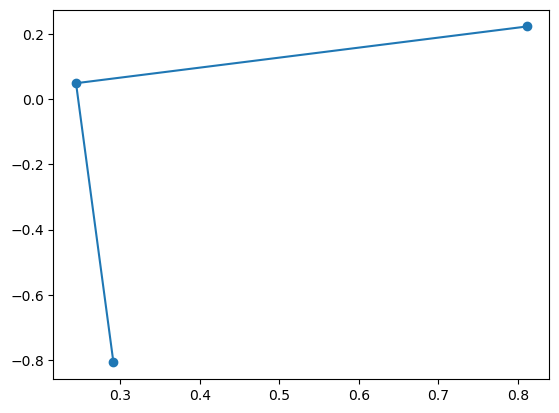

In [11]:
import matplotlib.pyplot as plt

plt.plot(h[:, 0].detach().numpy(), h[:,1].detach().numpy(), "o-")

### Attention Mechanism

![title](AttentionMechanism.png)

We have 2 output features per node, each feature will be inputted into the attention network so we get an attention layer with 4 inputs and 1 output

In [12]:
a = nn.Parameter(torch.zeros(size=(2*out_features, 1))) #xavier parameter inizializator
nn.init.xavier_uniform_(a.data, gain=1.414)
print(a.shape)

leakyrelu = nn.LeakyReLU(0.2)  # LeakyReLU

torch.Size([4, 1])


Create a vector with the possible combinations

In [13]:
a_input = (
    torch.cat(
        [h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1
    )
    .view(N, -1, 2 * out_features)
)

![title](a_input.png)

In [14]:
e = leakyrelu(torch.matmul(a_input, a).squeeze(2))

In [15]:
print(a_input.shape,a.shape)
print("")
print(torch.matmul(a_input,a).shape)
print("")
print(torch.matmul(a_input,a).squeeze(2).shape)

torch.Size([3, 3, 4]) torch.Size([4, 1])

torch.Size([3, 3, 1])

torch.Size([3, 3])


In [16]:
e

tensor([[-0.3354, -0.2286, -0.1423],
        [-0.0879,  0.0946,  0.5262],
        [-0.1058,  0.0050,  0.4367]], grad_fn=<LeakyReluBackward0>)

Graph with 3 nodes -> we get a 3x3 attention matrix

### Masked Attention

In [32]:
# Masked Attention
adj = torch.randint(2, (3, 3)) # Randomly create a matrix of 0s and 1s of shape (3, 3)

zero_vec  = -9e15*torch.ones_like(e) # tensor of same shape as e but with tiny values
print(zero_vec.shape)
zero_vec

torch.Size([3, 3])


tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])

In [19]:
attention = torch.where(adj > 0, e, zero_vec)
print(adj,"\n",e,"\n",zero_vec)
attention

tensor([[1, 0, 1],
        [1, 1, 1],
        [1, 1, 0]]) 
 tensor([[-0.3354, -0.2286, -0.1423],
        [-0.0879,  0.0946,  0.5262],
        [-0.1058,  0.0050,  0.4367]], grad_fn=<LeakyReluBackward0>) 
 tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


tensor([[-3.3539e-01, -9.0000e+15, -1.4229e-01],
        [-8.7860e-02,  9.4555e-02,  5.2618e-01],
        [-1.0576e-01,  5.0294e-03, -9.0000e+15]], grad_fn=<SWhereBackward0>)

In [20]:
attention = F.softmax(attention, dim=1)
h_prime   = torch.matmul(attention, h)

In [21]:
attention

tensor([[0.4519, 0.0000, 0.5481],
        [0.2470, 0.2965, 0.4565],
        [0.4723, 0.5277, 0.0000]], grad_fn=<SoftmaxBackward0>)

In [22]:
h_prime

tensor([[ 0.5763, -0.2426],
        [ 0.5146, -0.0829],
        [ 0.2663, -0.3556]], grad_fn=<MmBackward0>)

#### h_prime vs h

In [23]:
print(h_prime,"\n",h)

tensor([[ 0.5763, -0.2426],
        [ 0.5146, -0.0829],
        [ 0.2663, -0.3556]], grad_fn=<MmBackward0>) 
 tensor([[ 0.2912, -0.8082],
        [ 0.2441,  0.0495],
        [ 0.8113,  0.2237]], grad_fn=<MmBackward0>)


# Build the layer

In [15]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        
        '''
        TODO
        '''
        
    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

In [24]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    # 
        self.out_features  = out_features   # 
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.

        
        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice 
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]
        print(N)

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

# Use it

In [25]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

name_data = 'Cora'
dataset = Planetoid(root='/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


Processing...
Done!


In [28]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hidden = 8
        self.in_head = 8
        self.out_head = 1
        
        self.conv1 = GATConv(dataset.num_features, self.hidden, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hidden*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)
    
    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = GAT().to(device)
data = dataset[0].to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()
    
    

cuda
tensor(1.9464, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7322, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5908, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6174, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5742, device='cuda:0', grad_fn=<NllLossBackward0>)


In [29]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8230
